In [1]:
# %pip install fastf1
# %pip list

import logging, sys
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.lines as mlines
import fastf1
from fastf1 import plotting
import mercury as mr

# enable some matplotlib patches for plotting timedelta values and load
# FastF1's default color scheme
plotting.setup_mpl(misc_mpl_mods=False)
logging.disable(sys.maxsize)

In [2]:
def init_fastf1(year, event_name):
    """
    load a session and its telemetry data
    year: f1 season by year
    event_name: name of grand prix
    returns session object
    """
    session = fastf1.get_session(year, event_name, 'Qualifying')
    session.load()

    return session


def get_keys_from_value(d, val):
    return [k for k, v in d.items() if v == val][0]


def add_honey_badger():
    """
    check if danny ric is in the driver dict
    """
    if plotting.DRIVER_TRANSLATE.get('RIC') is None:
        plotting.DRIVER_TRANSLATE.update({'RIC': 'daniel ricciardo'})

    # Liam Lawson
    if plotting.DRIVER_TRANSLATE.get('LAW') is None:
        plotting.DRIVER_TRANSLATE.update({'LAW': 'liam lawson'})


def get_driver_abb_list(session, event_name):
    """
    generate list of drivers names
    """

    if schedule[(schedule['EventName'] == event_name)].iloc[0]['RoundNumber'] >= 11:
        add_honey_badger()

    driver_list = []

    for driver in session.drivers:
        driver_laps = session.laps.pick_driver(driver)

        abb = driver_laps['Driver'].iloc[0]

        # print(abb)
        driver_name = plotting.DRIVER_TRANSLATE.get(abb).split()
        driver_name = [name.capitalize() for name in driver_name]
        driver_name = ' '.join(driver_name)
        
        driver_list.append(driver_name)

    return driver_list


# custom lap time delta function
def custom_delta_time(ref_lap, comp_lap):
    """
    use laps with interpolated edges
    start is 0 distance and last data point in telemetry matches lap time
    interpolate comp lap to match ref lap's distance intervals
    """
    comp_interp_time = comp_lap['Time'].dt.total_seconds().to_numpy()
    
    comp_interp_time = np.interp(ref_lap['Distance'].to_numpy(), comp_lap['Distance'].to_numpy(), comp_interp_time)
    
    delta = comp_interp_time - ref_lap['Time'].dt.total_seconds()
    
    return delta


def get_driver_abb(driver_name):
    return get_keys_from_value(plotting.DRIVER_TRANSLATE, driver_name.lower())


def format_laptime(timedelta):
    minutes, seconds = divmod(timedelta.seconds, 60)
    seconds = seconds + timedelta.microseconds / 1000000
    
    return f"{int(minutes)}:{'{:.3f}'.format(seconds)}"


def generate_infographic(ref_lap, comp_lap):
    delta = round(ref_lap['LapTime'].total_seconds() - comp_lap['LapTime'].total_seconds(), 3)
    info = {'Driver': [ref_lap['Driver'], comp_lap['Driver'], 'Delta'],
        'Lap Time': [format_laptime(ref_lap['LapTime']), format_laptime(comp_lap['LapTime']), delta],
        'Tire Compound': [ref_lap['Compound'], comp_lap['Compound'], None],
        'Is Fresh Tire?': [ref_lap['FreshTyre'], comp_lap['FreshTyre'], None],
        'Tire Age (Laps)': [ref_lap['TyreLife'], comp_lap['TyreLife'], '']
        }

    return pd.DataFrame(data=info)



mercury.App

mercury.Select

mercury.Select

mercury.Select

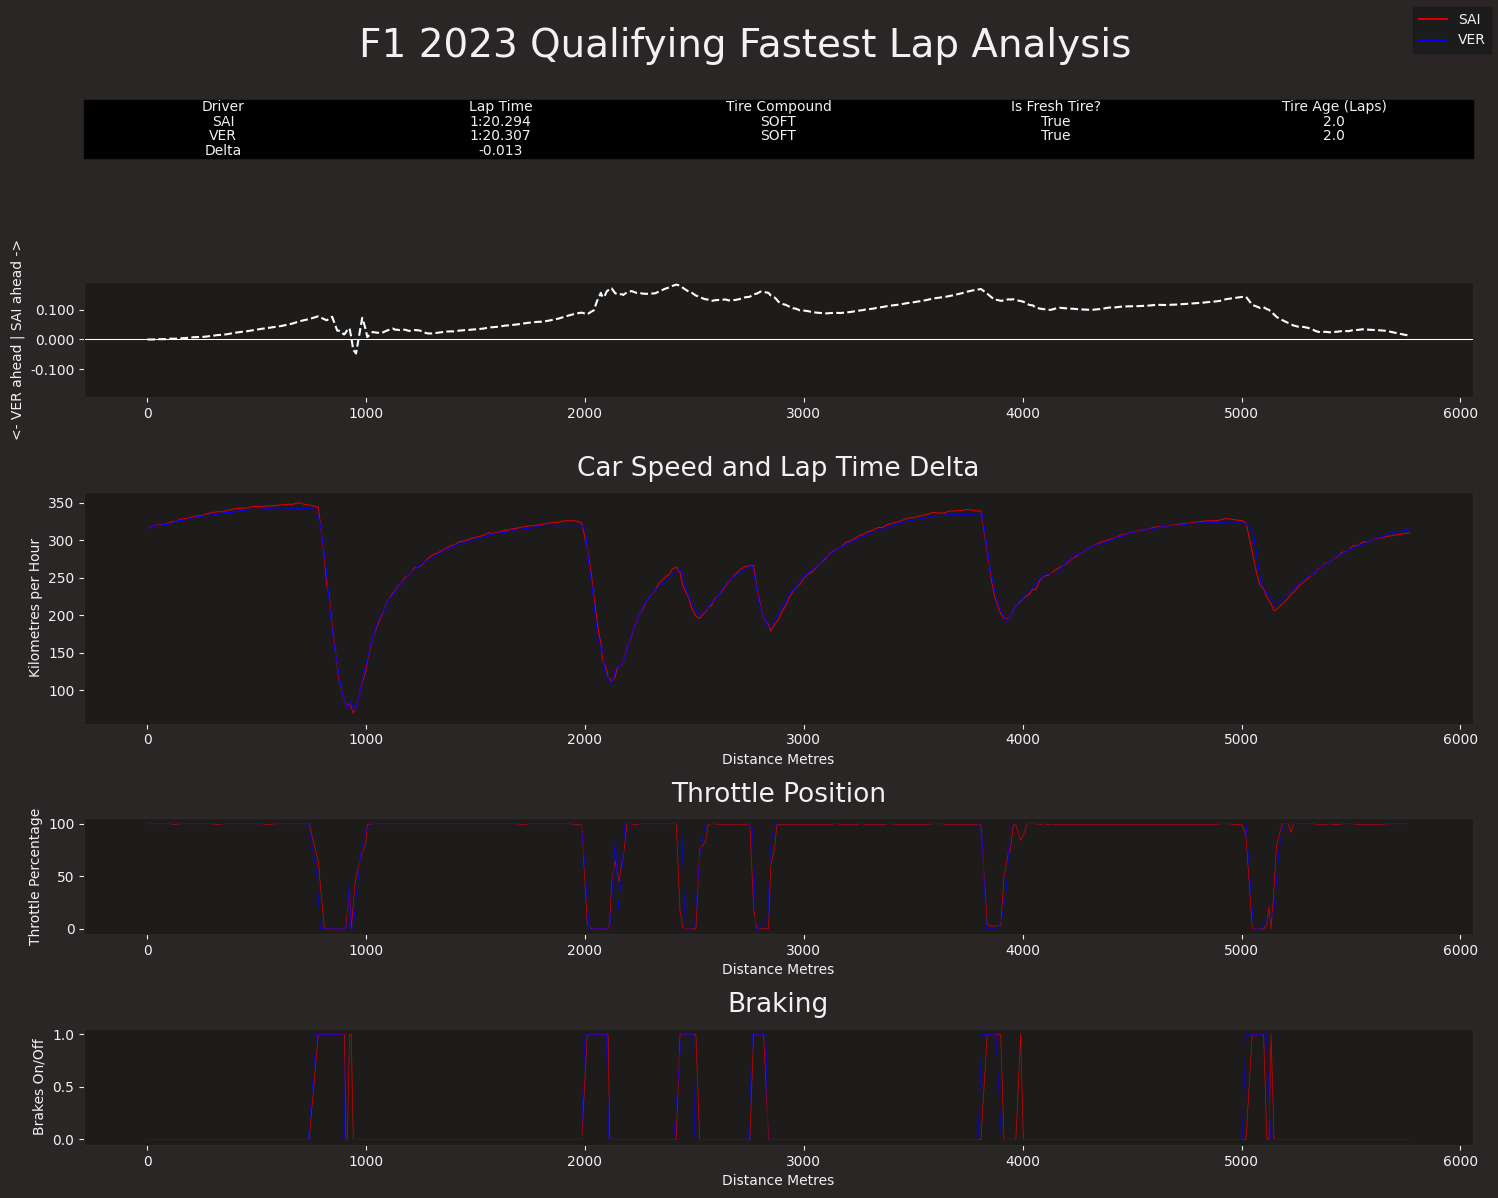

In [3]:
def draw_telemetry_analysis(ref_driver, comp_driver):
    """
    specify two drivers for their qualification fastest lap analysis
    """

    # get driver abb
    ref_abb = get_driver_abb(ref_driver)
    comp_abb = get_driver_abb(comp_driver)
    
    # get lap objects
    ref_lap = session.laps.pick_driver(ref_abb).pick_fastest()
    comp_lap = session.laps.pick_driver(comp_abb).pick_fastest()

    # get telemetry with interpolated edges
    ref_tel = ref_lap.get_car_data(interpolate_edges=True).add_distance()
    comp_tel = comp_lap.get_car_data(interpolate_edges=True).add_distance()

    # set up colours
    comp_color = fastf1.plotting.team_color(comp_lap['Team'])

    # if comparing teammates, then make ref driver line white
    if ref_lap['Team'] != comp_lap['Team']:
        ref_color = fastf1.plotting.team_color(ref_lap['Team'])
    else:
        ref_color = '#ffffff'

    # normalize for slight variation in distance
    dist_norm_factor = ref_tel['Distance'].max()/comp_tel['Distance'].max()
    comp_tel['Distance'] = comp_tel['Distance'] * dist_norm_factor

    # calculate delta time with interpolation
    delta_time = custom_delta_time(ref_tel, comp_tel)

    # set up figure and subplots
    fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(5, 1, gridspec_kw={'height_ratios': [1, 1, 2, 1, 1]}, figsize=(15,12))

    fig.suptitle('F1 2023 Qualifying Fastest Lap Analysis', fontsize=28)

    # printed table    
    info_df = generate_infographic(ref_lap, comp_lap)
    ax0.table(cellText=info_df.values, colLabels=info_df.columns, loc='center',
        cellColours=[['black'] * 5, ['black'] * 5, ['black'] * 5],
        colColours=['black'] * 5,
        cellLoc='center'
        )
    ax0.axis('off')


    # lap time delta
    # ax3 = ax1.twinx()
    ax1.plot(ref_tel['Distance'], delta_time, '--', color='white')
    ax1.set_ylabel(f"<- {comp_lap.Driver} ahead | {ref_lap.Driver} ahead ->")
    ax1.set_ylim(-delta_time.abs().max() - 0.01, delta_time.abs().max() + 0.01)
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax1.axhline(y=0, color='white', linestyle='-', linewidth=0.75)


    # speed
    ax2.plot(ref_tel['Distance'], ref_tel['Speed'],
            color=ref_color, linewidth=0.75)
    ax2.plot(comp_tel['Distance'], comp_tel['Speed'],
            color=comp_color, linewidth=0.75)

    ax2.set_title('Car Speed and Lap Time Delta')
    ax2.set_ylabel('Kilometres per Hour')
    ax2.set_xlabel('Distance Metres')
   

    # throttle
    ax3.plot(ref_tel['Distance'], ref_tel['Throttle'],
            color=ref_color, linewidth=0.5)
    ax3.plot(comp_tel['Distance'], comp_tel['Throttle'],
            color=comp_color, linewidth=0.5)
    ax3.set_title('Throttle Position')
    ax3.set_ylabel('Throttle Percentage')
    ax3.set_xlabel('Distance Metres')
 

    # brake
    ax4.plot(ref_tel['Distance'], ref_tel['Brake'],
            color=ref_color, linewidth=0.5)
    ax4.plot(comp_tel['Distance'], comp_tel['Brake'],
            color=comp_color, linewidth=0.5)
    ax4.set_title('Braking')
    ax4.set_ylabel('Brakes On/Off')
    ax4.set_xlabel('Distance Metres')
    

    # finish
    # fig.legend([ref_lap.Driver, comp_lap.Driver])
    ref_line = mlines.Line2D([], [], color=ref_color, markersize=8)
    comp_line = mlines.Line2D([], [], color=comp_color, markersize=8)
    fig.legend(handles=[ref_line, comp_line], labels=[ref_lap.Driver, comp_lap.Driver])

    plt.tight_layout()
    plt.show()
    
# get schedule
schedule = fastf1.get_event_schedule(2023, include_testing=False)

app = mr.App(title='2023 F1 Qualifying Lap Telemetry Analysis',
             description='Visualize telemetry for the fastest F1 qualifying laps',
             show_code=True)

event_choices = schedule[(schedule['EventDate'] < datetime.now())]['EventName']

event = mr.Select(label='Grand Prix to Analyze', choices=event_choices,
                       value='Italian Grand Prix')

session = init_fastf1(2023, event.value)

driver_list = get_driver_abb_list(session, event.value)

ref_driver = mr.Select(label='Select reference driver', choices=driver_list, value='Carlos Sainz')
comp_driver = mr.Select(label='Select comparison driver', choices=driver_list, value='Max Verstappen')

draw_telemetry_analysis(ref_driver.value, comp_driver.value)